In [57]:
# -------------------- INSTALL & IMPORT --------------------

!pip install kagglehub kaggle --quiet
!pip install transformers
!pip install sentencepiece
!pip install jiwer
!pip install datasets
!pip install evaluate
!pip install -U accelerate

!pip install matplotlib
!pip install protobuf==3.20.1
!pip install tensorboard

In [58]:
# -------------------- INSTALL & IMPORT --------------------

import os
import torch
import evaluate
import numpy as np
import pandas as pd
import glob as glob
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from PIL import Image
from tqdm.notebook import tqdm
from dataclasses import dataclass
from torch.utils.data import Dataset
from transformers import (
    VisionEncoderDecoderModel,
    TrOCRProcessor,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    default_data_collator
)

block_plot = False
plt.rcParams['figure.figsize'] = (12, 9)

In [59]:
os.environ["TOKENIZERS_PARALLELISM"] = 'false'

In [60]:
# -------------------- SEED & DEVICE --------------------

def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [93]:
# -------------------- CONFIG --------------------
from dataclasses import dataclass

# Training Config
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE: int = 8
    EPOCHS: int = 10
    LEARNING_RATE: float = 3e-3
    OUTPUT_DIR: str = './trocr-imgur5k'

#  Dataset Config
@dataclass(frozen=True)
class DatasetConfig:
    IMAGES_FOLDER: str = 'cropped_imgs'
    LABELS_FILE: str = 'labels.txt'

# Model Config
@dataclass(frozen=True)
class ModelConfig:
    MODEL_NAME: str = 'microsoft/trocr-small-handwritten'


In [94]:
# -------------------- DOWNLOAD DATA --------------------
import kagglehub
path = kagglehub.dataset_download("gopichandu1/imgur5k-cropped-tfrecords")

In [95]:
# -------------------- PARSE TFRECORDS --------------------
def parse_example(example_proto):
    features = {
        'label': tf.io.FixedLenFeature([], tf.string),
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'chans': tf.io.FixedLenFeature([], tf.int64),
        'image': tf.io.FixedLenFeature([], tf.string),
    }
    parsed = tf.io.parse_single_example(example_proto, features)
    image_raw = tf.image.decode_png(parsed['image'], channels=1)
    image_raw = tf.image.grayscale_to_rgb(tf.image.convert_image_dtype(image_raw, tf.uint8))
    return image_raw, parsed['label']

os.makedirs("cropped_imgs", exist_ok=True)
with open("labels.txt", 'w') as f:
    count = 0
    for record in ["IMGUR5K_train_0.tfrecord", "IMGUR5K_train_1.tfrecord"]:
        tf_path = os.path.join(path, "IMGUR5K_train", record)
        dataset = tf.data.TFRecordDataset(tf_path).map(parse_example)
        for image_tensor, label_tensor in dataset.take(2000):
            label = label_tensor.numpy().decode('utf-8')
            fname = f"img_{count}.png"
            Image.fromarray(image_tensor.numpy()).save(f"cropped_imgs/{fname}")
            f.write(f"{fname}\t{label}\n")
            count += 1

In [96]:
train_folder = os.path.join(path, "IMGUR5K_train")
print("📂 Files in IMGUR5K_train:")

for file in os.listdir(train_folder):
    if file.endswith(".tfrecord"):
        print("-", file)

📂 Files in IMGUR5K_train:
- IMGUR5K_train_1.tfrecord
- IMGUR5K_train_3.tfrecord
- IMGUR5K_train_0.tfrecord
- IMGUR5K_train_2.tfrecord


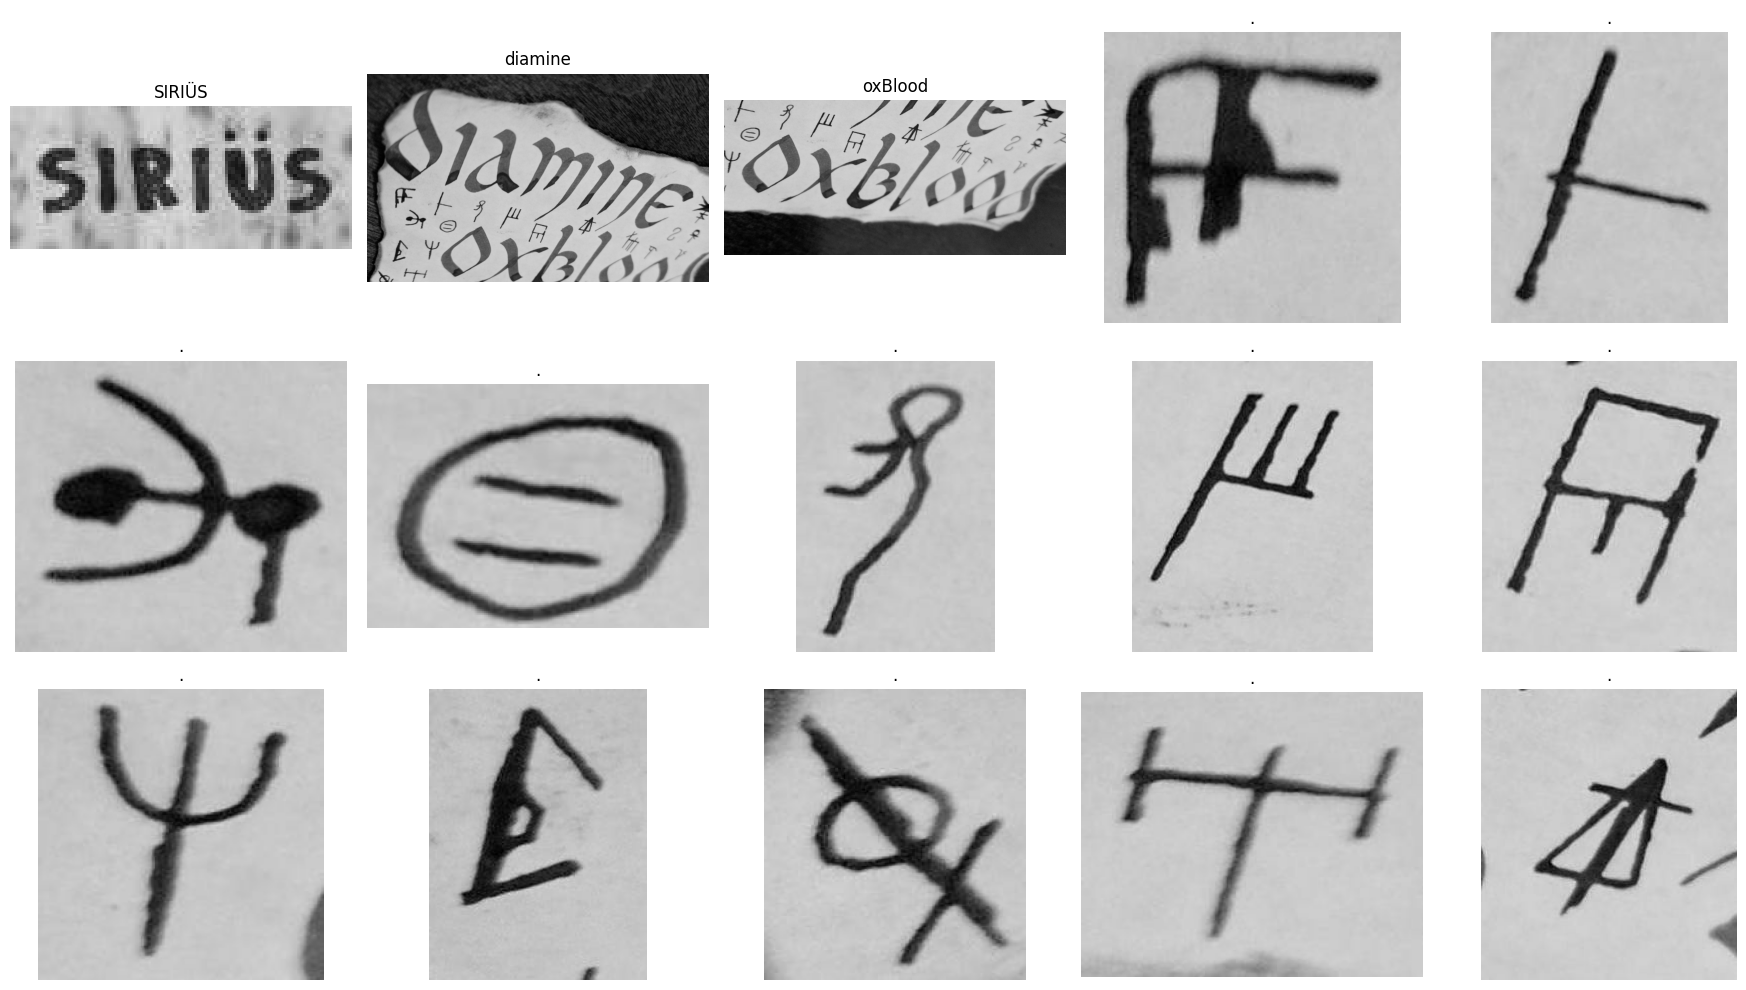

In [97]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Load the labels
samples = []
with open("labels.txt", "r") as f:
    for line in f.readlines():
        filename, label = line.strip().split("\t")
        samples.append((filename, label))

# Show first 15 samples
plt.figure(figsize=(18, 10))
for i in range(15):
    filename, label = samples[i]
    img_path = os.path.join("cropped_imgs", filename)
    image = Image.open(img_path)

    plt.subplot(3, 5, i + 1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(label[:25] + "..." if len(label) > 25 else label)

plt.tight_layout()
plt.show()


In [98]:
# -------------------- LABEL CLEANING --------------------
import re
df = pd.read_csv("labels.txt", sep="\t", names=["file_name", "text"])
df = df[~df['text'].isin(['.', ',', '-', '', '_'])]
df["text"] = df["text"].str.strip().str.lower()
df['text'] = df['text'].apply(lambda x: re.sub(r'[^a-z0-9 ]+', '', x))
df = df[df['text'].str.len() > 1]
df = df.groupby('text').apply(lambda x: x.sample(min(20, len(x)), random_state=42)).reset_index(drop=True)

<ipython-input-98-11d277310606>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('text').apply(lambda x: x.sample(min(20, len(x)), random_state=42)).reset_index(drop=True)


In [99]:
import pandas as pd

df = pd.read_csv("labels.txt", sep="\t", names=["file_name", "text"])
df.head(10)

,file_name,text
0,img_0.png,SIRIÜS
1,img_1.png,diamine
2,img_2.png,oxBlood
3,img_3.png,.
4,img_4.png,.
5,img_5.png,.
6,img_6.png,.
7,img_7.png,.
8,img_8.png,.
9,img_9.png,.


In [100]:
df.head(10)

,file_name,text
0,img_0.png,SIRIÜS
1,img_1.png,diamine
2,img_2.png,oxBlood
3,img_3.png,.
4,img_4.png,.
5,img_5.png,.
6,img_6.png,.
7,img_7.png,.
8,img_8.png,.
9,img_9.png,.


In [101]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_df.to_csv("train_labels.txt", sep="\t", index=False, header=False)

val_df.to_csv("val_labels.txt", sep="\t", index=False, header=False)


In [102]:
train_df.head(10)


,file_name,text
2988,img_2993.png,.
1575,img_1575.png,styles
506,img_506.png,TREMBLING
3591,img_3596.png,abcdefghijklmnopqrstuvwxyz
3560,img_3565.png,over
3218,img_3223.png,(plus
2510,img_2515.png,Communication
500,img_500.png,GAZEd
1105,img_1105.png,"hot,"
1075,img_1075.png,but


In [103]:
val_df.head(10)

,file_name,text
1760,img_1760.png,To
3015,img_3020.png,Martin's.
1770,img_1770.png,you
3994,img_3999.png,flex
2099,img_2099.png,jumps
2641,img_2646.png,jumped
1417,img_1417.png,"Hub,"
755,img_755.png,to
109,img_109.png,that
3475,img_3480.png,P


In [104]:
# -------------------- TRANSFORMS --------------------

from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.GaussianBlur(kernel_size=3)
])

In [105]:
# -------------------- DATASET --------------------
class Imgur5KCroppedDataset(Dataset):
    def __init__(self, images_folder, labels_file, processor, transform=None):
        self.processor = processor
        self.samples = []
        self.transform = transform
        with open(labels_file, "r") as f:
            for line in f:
                if "\t" not in line: continue
                image_name, label = line.strip().split("\t")
                image_path = os.path.join(images_folder, image_name)
                if os.path.exists(image_path):
                    self.samples.append((image_path, label))

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform: image = self.transform(image)
        encoding = self.processor(image, text=label, return_tensors="pt", padding="max_length", truncation=True, max_length=64)
        return {"pixel_values": encoding["pixel_values"].squeeze(), "labels": encoding["labels"].squeeze()}


In [106]:
# -------------------- MODEL & PROCESSOR --------------------
import torch
from transformers import VisionEncoderDecoderModel

processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)
model = VisionEncoderDecoderModel.from_pretrained(ModelConfig.MODEL_NAME)
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.vocab_size = model.config.decoder.vocab_size

# Define device before moving the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Config of the encoder: <class 'transformers.models.deit.modeling_deit.DeiTModel'> is overwritten by shared encoder config: DeiTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 384,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "model_type": "deit",
  "num_attention_heads": 6,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 384,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 384,
  "d_

VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(in_features=384, out_features=1536, bias=True)
        

In [107]:
# -------------------- DATA LOAD --------------------
train_dataset = Imgur5KCroppedDataset("cropped_imgs", "train_labels.txt", processor, transform=train_transforms)
val_dataset = Imgur5KCroppedDataset("cropped_imgs", "val_labels.txt", processor)

In [108]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))


Number of training examples: 3201
Number of validation examples: 799


In [109]:
encoding = train_dataset[0]
for k, v in encoding.items():
    print(f"{k}: shape {v.shape}")


pixel_values: shape torch.Size([3, 384, 384])
labels: shape torch.Size([64])


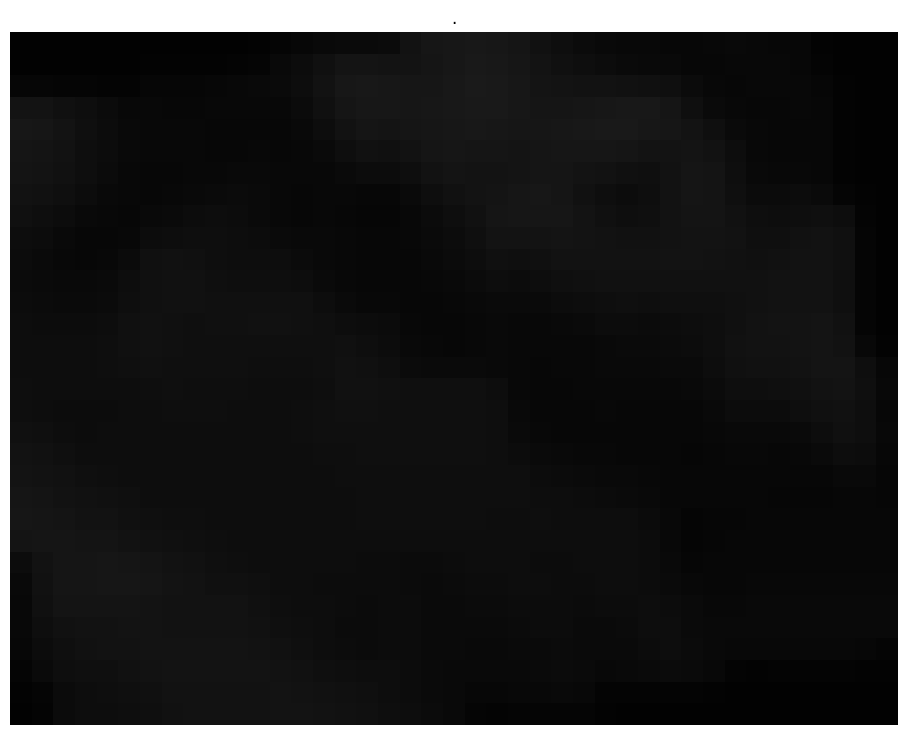

In [110]:
import matplotlib.pyplot as plt
from PIL import Image

# Fetch the original image path and label
img_path, label = train_dataset.samples[0]

# Open and transform
image = Image.open(img_path).convert("RGB")
if hasattr(train_dataset, "transform") and train_dataset.transform:

    image = train_dataset.transform(image)

# Show the image
plt.imshow(image)
plt.title(label)
plt.axis("off")
plt.show()


In [111]:
labels = encoding["labels"]
labels = labels.clone()
labels[labels == -100] = processor.tokenizer.pad_token_id  # replace -100 with pad token
decoded_text = processor.tokenizer.decode(labels, skip_special_tokens=True)

print("Decoded Label:", decoded_text)


Decoded Label: .


In [112]:
import torch
from transformers import VisionEncoderDecoderModel

# 🧠 Initialize model from config
model = VisionEncoderDecoderModel.from_pretrained(ModelConfig.MODEL_NAME)

# ✅ Set tokenizer and generation settings
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.max_length = 16
model.config.early_stopping = True
model.config.num_beams = 4

# ⚡ Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 📊 Print model and parameter counts
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f"\n🔢 Total parameters: {total_params:,}")

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"🎯 Trainable parameters: {trainable_params:,}")


Config of the encoder: <class 'transformers.models.deit.modeling_deit.DeiTModel'> is overwritten by shared encoder config: DeiTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 384,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "model_type": "deit",
  "num_attention_heads": 6,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 384,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 384,
  "d_

VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(in_features=384, out_features=1536, bias=True)
        

In [113]:
optimizer = optim.AdamW(
    model.parameters(), lr=TrainingConfig.LEARNING_RATE, weight_decay=0.0005
)

In [114]:
# -------------------- CER METRIC --------------------
cer_metric = evaluate.load("cer")

def compute_cer(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    exact = sum(p.strip() == l.strip() for p, l in zip(pred_str, label_str)) / len(pred_str)

    return {
        "eval_cer": cer_metric.compute(predictions=pred_str, references=label_str),
        "eval_exact_match": exact
    }


In [115]:
# -------------------- TRAIN --------------------
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer ,EarlyStoppingCallback

training_args = Seq2SeqTrainingArguments(
    output_dir=TrainingConfig.OUTPUT_DIR,
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    per_device_train_batch_size=TrainingConfig.BATCH_SIZE,
    per_device_eval_batch_size=TrainingConfig.BATCH_SIZE,
    predict_with_generate=True,
    load_best_model_at_end=True,
    metric_for_best_model="cer",
    greater_is_better=False,
    num_train_epochs=TrainingConfig.EPOCHS,
    fp16=True,
    report_to="tensorboard"
)

In [116]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    tokenizer=processor.tokenizer,
    compute_metrics=compute_cer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator
)

<ipython-input-116-9b8ab87f424b>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [117]:
res = trainer.train()

Epoch,Training Loss,Validation Loss,Cer,Exact Match
1,0.489100,0.168599,0.949541,0.105131
2,0.139700,0.129975,0.743775,0.287860
3,0.088700,0.085266,0.481979,0.451815
4,0.065900,0.084427,0.488532,0.428035
5,0.050600,0.070484,0.387287,0.496871
6,0.042700,0.065910,0.364024,0.509387
7,0.033600,0.065948,0.386959,0.506884
8,0.027900,0.064858,0.371887,0.503129


/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:1667: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  generation_config.max_length = generation_config.max_new_tokens + input_ids_length
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 16, 'early_stopping': True, 'num_beams': 4}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  Arguments:


In [118]:
# -------------------- EVALUATION --------------------
metrics = trainer.evaluate()
print("\nFinal CER:", metrics.get('eval_cer', 'N/A'))
print("Final Exact Match Accuracy:", metrics.get('eval_exact_match', 'N/A'))



Final CER: 0.3640235910878113
Final Exact Match Accuracy: 0.509386733416771


In [119]:
# ✅ Then save
trainer.save_model("trocr-imgur5k-final")
processor.save_pretrained("trocr-imgur5k-final")

[]

Inference

In [120]:
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load processor and model from the saved directory
processor = TrOCRProcessor.from_pretrained("trocr-imgur5k-final")
model = VisionEncoderDecoderModel.from_pretrained("trocr-imgur5k-final").to(device)


Config of the encoder: <class 'transformers.models.deit.modeling_deit.DeiTModel'> is overwritten by shared encoder config: DeiTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 384,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "model_type": "deit",
  "num_attention_heads": 6,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 384,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 384,
  "d_

In [121]:
from PIL import Image

def read_and_show(image_path):
    image = Image.open(image_path).convert("RGB")
    return image


In [122]:
def ocr(image, processor, model):
    pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)
    generated_ids = model.generate(pixel_values, num_beams=4, early_stopping=True, max_length=16)
    return processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [123]:
def run_inference_on_validation(num_samples=20):
    val_df = pd.read_csv("val_labels.txt", sep="\t", names=["file_name", "text"])
    for i, row in tqdm(val_df.iterrows(), total=min(len(val_df), num_samples)):
        if i == num_samples: break
        img_path = os.path.join("cropped_imgs", row["file_name"])
        img = read_and_show(img_path)
        pred = ocr(img, processor, model)
        plt.figure(figsize=(7, 4))
        plt.imshow(img)
        plt.title(f"Predicted: {pred} | Actual: {row['text']}")
        plt.axis("off")
        plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

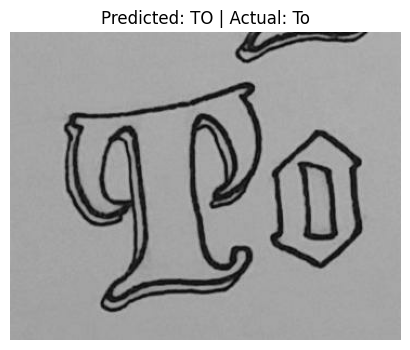

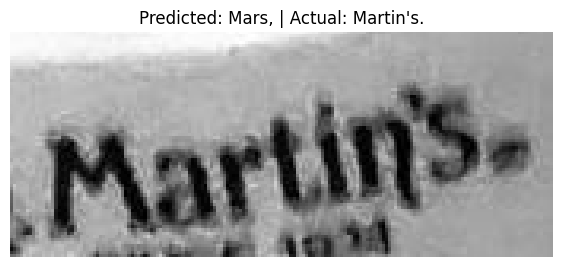

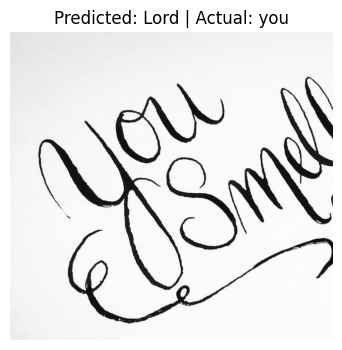

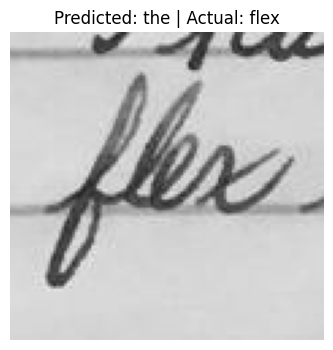

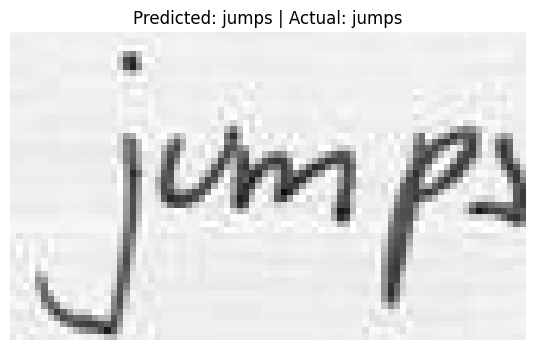

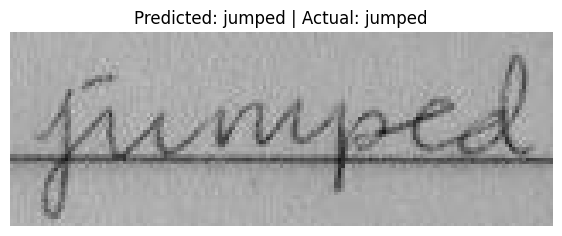

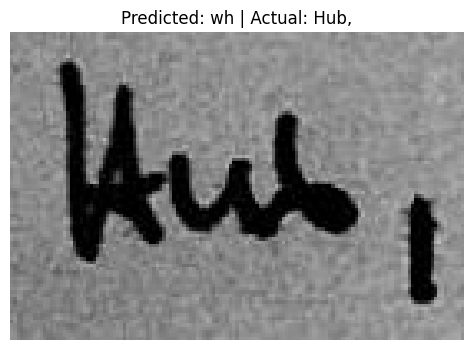

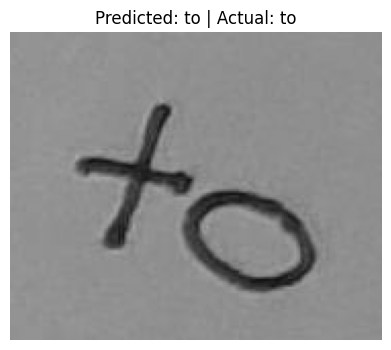

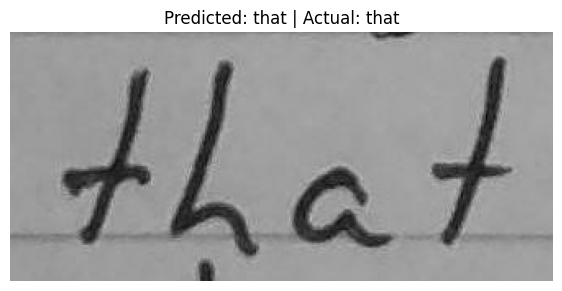

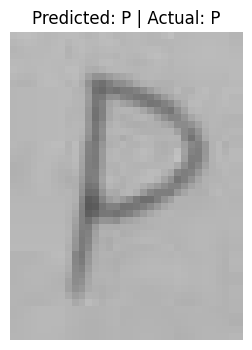

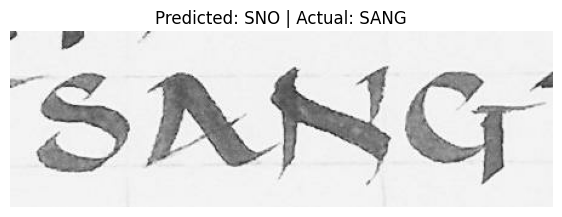

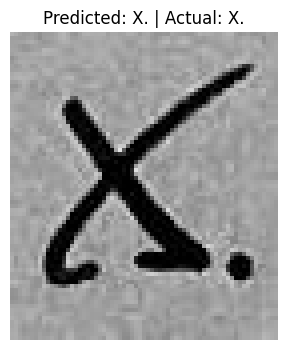

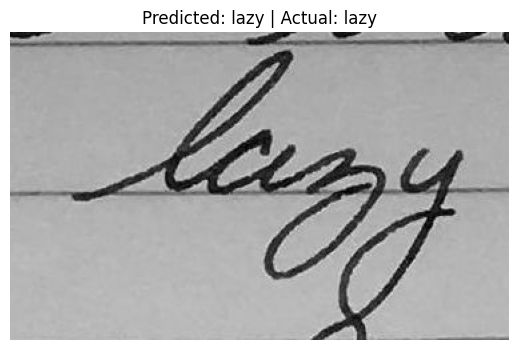

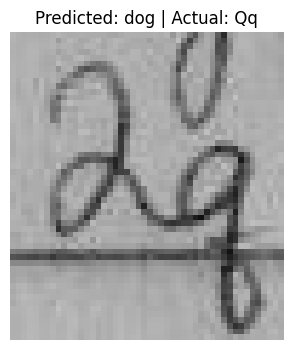

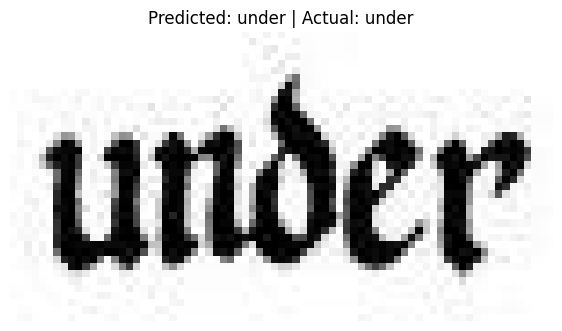

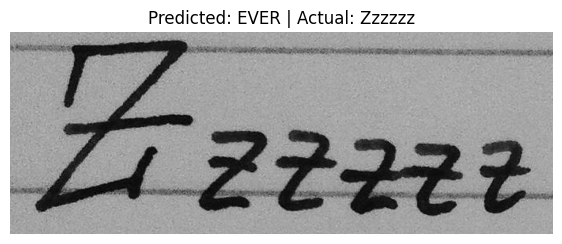

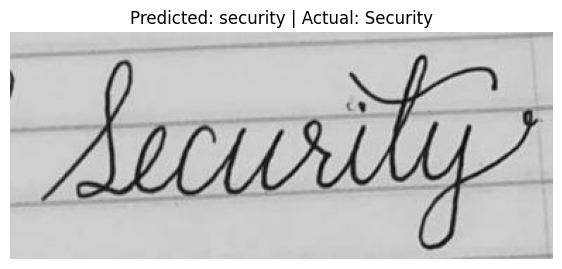

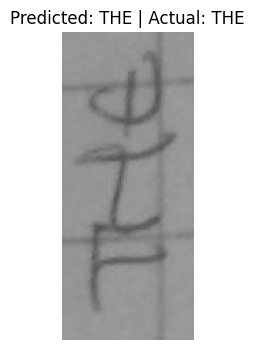

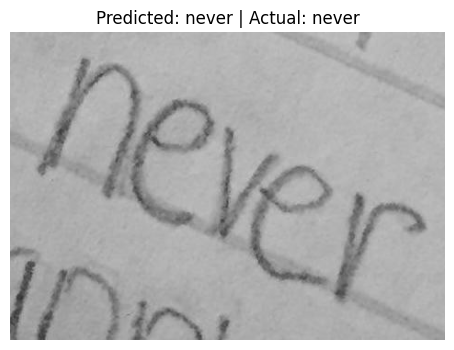

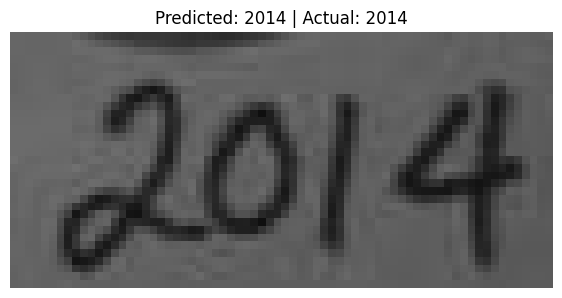

In [124]:
run_inference_on_validation(num_samples=20)
